# Data Science for Finance: Sector ETFs Investment Strategies Analysis

Final Project in Financial data science
The goal of the project is to create 5 different trading strategies for using the Sector ETFs to get good portfolio performance.

XLK - Technology <br/>
XLE - Energy <br/>
XLF - Financials <br/>
XLV - Health Care <br/>
XLRE -  Real Estate <br/>
XLB - Materials <br/>
XLY - Consumer Discretionary <br/>
XLP - Consumer Staples <br/>
XLU - Utilities <br/>
XLI - Industrials <br/>
IYZ - Telecommunications

You can use technical analysis (Bollinger bands, MACD, RSI, Moving Averages) or any kind of fundamental or macro analysis (based on the interest rate, 10 year yield, unemployment rate, Inflation rate, etc).
You can rebalance your portfolio every day, every week or every quarter. Assume you have 1M$ as initial available cash. You do NOT have to utilize all the cash at each point. Your goal is to rebalance the allocation between the various sector ETFs and the available cash.
You need to describe your strategies, implement them and test them on 3 date ranges:
1.	1.1.2010-now
2.	1.1.2019-now
3.	1.1.2021-now
Rank the 5 strategies for each time range based on their performance.


# Introduction

In this project, we assume we have 1,000,000$ as initial available budget. We will need
to decide how to utilize it and to rebalance the allocation between Sector ETFs and our
cash. The objective of this project is to maximize the portfolio performance using 5
different strategies for the Sector ETFs, implement and test them on three date ranges.
Then, we will compare those strategies, derive insights, and rank them by this
comparison for each date range. By the end of every date range, we’ll get the updated
total value of our portfolio. We could see if we earned or lost through the period and by
how much for each approach. The total value of the portfolio at the end of each period
will be the main indicator for the performance of the strategy.
The first step was to import and install the Pandas Technical Analysis package to get the
technical indicators that we need to use in this project. For each strategy we need to
document all the transactions in a log data frame (save to csv), to record and track the
mean change of the securities we bought and sold, and implement the money allocation
of each approach. After each transaction, we adjust the portfolio (remove or adding
securities to the log) and amount of cash and calculate the normalized profit/loss.

## SMA

In [55]:
import yfinance as yf

In [56]:
import pandas as pd
import numpy as np
import datetime as dt
import math
import pandas_ta as pta
import warnings
warnings.filterwarnings("ignore")


In [57]:
#data = pd.read_csv("r1kdata.csv", index_col="Date", parse_dates=True)
#volumechanges = pd.read_csv("r1kvolume.csv", index_col="Date", parse_dates=True).pct_change()*100
#volumechanges.head()

#today = dt.date(2010, 1, 1)
#simend = dt.date(2022, 2, 25)
#tickers = []
#transactionid = 0
#money = 1000000
#portfolio = {}
#activelog = []
#transactionlog = []

def getprice(date, ticker):
    global prices
    try:
        price = prices.loc[str(date)][ticker]
        return price
    except Exception as e:
        return None


def transaction(id, ticker, amount, price, type,profit):
    #here we document everything
    global transactionid
    if type == "buy":
        #exp_date = today + dt.timedelta(days=14)
        transactionid += 1
    #else:
        #exp_date = today
        #create record of new transaction
    if type == "sell":
        data = {"id": id, "ticker": ticker, "amount": amount, "price": price, "date": today, "type": type,
                "profit": profit}
    elif type == "buy":
        data = {"id": transactionid, "ticker": ticker, "amount": amount, "price": price, "date": today, "type": type,
                "profit": profit}
        activelog.append(data)
    #append to tarsnaction log wich we create in the main
    transactionlog.append(data)


def buy(interestlst, allocated_money):
    #we receive the mean change which is probably a small number of stocks,
    #and how much money we have for this stock
    global money, portfolio
    for item in interestlst:
        #we do loop on all stocks in the interest list
        price = getprice(today, item)
        if not pd.isnull(price):
            #we look at the total allocation of money we have divided by price
            #hence how many shares we buy
            quantity = math.floor(allocated_money/price)
            money -= quantity*price
            #we update the number of shares per ticker
            portfolio[item] += quantity
            #we record the transaction
            transaction(0, item, quantity, price, "buy", 0)


def sell(interestlst_sma):
    global money, portfolio, prices, today
    #sell happens every 14 days so we check if 14 days passed since we bought
    itemstoremove = []
    for i in range(len(activelog)):
        #we go through all records in the log
        log = activelog[i]
        #check if log smaller than today
        #we should have sold it already - it means the date passed and we didnt sell yet
        #so if the date passed and the type is buy we sell
        if log["ticker"] in interestlst_sma and log["type"] == "buy":
            tickprice = getprice(today, log["ticker"])
            if not pd.isnull(tickprice):
                #we adjust the money amount
                money += log["amount"]*tickprice
                #we diduct the numbers of shares in portfolio
                portfolio[log["ticker"]] -= log["amount"]
                #calculate normalized profit
                profit = log["amount"]*tickprice - log["amount"]*log["price"]
                #we document the trasaction
                transaction(log["id"], log["ticker"], log["amount"], tickprice, "sell",profit)
                #we remove it fromt the active log 
                itemstoremove.append(i)
            '''else:
                log["exp_date"] += dt.timedelta(days=1)'''
    itemstoremove.reverse()
    for elem in itemstoremove:
        activelog.remove(activelog[elem])


def simulation():
    global today, sma, money
    interestlstsell = []*0
    interestlstbuy = []*0
    #start_date = today - dt.timedelta(days=14)
    #get the average change in volume of the ticker in the two weeks range
    series = sma.loc[today.strftime('%m-%d-%Y')]
    for j in tickers_table:
        if series[f'SMA_30_{j}'] > series[f'SMA_100_{j}']:
            interestlstsell.append(j)
        if series[f'SMA_30_{j}'] < series[f'SMA_100_{j}']:
            interestlstbuy.append(j)
            
    if len(interestlstbuy) > 0:
        moneyToAllocate = currentvalue()/(2*len(interestlstbuy))
        buy(interestlstbuy, moneyToAllocate)
    
    if len(interestlstsell) > 0:
        sell(interestlstsell)

def getindices():
    #get symbols of s&p500 and save them in tickers
    global tickers
    f = open("symbols2.txt", "r")
    for line in f:
        tickers.append(line.strip())
    f.close()


def tradingday():
    global prices, today
    return np.datetime64(today) in list(prices.index.values)


def currentvalue():
    #for each ticker get the price today
    global money, portfolio, today, prices
    value = money
    for ticker in tickers:
        tickprice = getprice(today, ticker)
        if not pd.isnull(tickprice):
            #if not null, update the total value by the price multiple by how 
            #many stocks we have. add it to total value of the portfolio.
            value += portfolio[ticker]*tickprice
            #return it converted as int
    return int(value*100)/100


def main():
    global today
    getindices()
    for ticker in tickers:
        #for each ticker how many shares we have
        portfolio[ticker] = 0
    while today < simend:
        while not tradingday():
            today += dt.timedelta(days=1)
        simulation()
        #calc curr value of the portfolio
        currentpvalue = currentvalue()
        print(currentpvalue, today)
        value['Date'].append(today)
        value['Money'].append(money)
        value['Value'].append(currentpvalue)
        #we look at trasaction every week. but why? 
        #its a little lower if we do every day! 1 million less.
        today += dt.timedelta(days=7)

    df = pd.DataFrame(transactionlog)
    df.to_csv('transactions.csv',index=False)

    


In [58]:
tickers_table = ['XLK','XLE','XLF','XLV','XLRE',
                 'XLB','XLY','XLP','XLU','XLI','IYZ']

[*********************100%***********************]  11 of 11 completed
1000000.0 2010-01-04
1000000.0 2010-01-11
1000000.0 2010-01-19
1000000.0 2010-01-26
1000000.0 2010-02-02
1000000.0 2010-02-09
1000000.0 2010-02-16
1000000.0 2010-02-23
1000000.0 2010-03-02
1000000.0 2010-03-09
1000000.0 2010-03-16
1000000.0 2010-03-23
1000000.0 2010-03-30
1000000.0 2010-04-06
1000000.0 2010-04-13
1000000.0 2010-04-20
1000000.0 2010-04-27
1000000.0 2010-05-04
1000000.0 2010-05-11
1000000.0 2010-05-18
1000000.0 2010-05-25
998951.41 2010-06-01
1001937.63 2010-06-08
1075408.67 2010-06-15
1041803.54 2010-06-22
935858.7 2010-06-29
904706.35 2010-07-06
1110920.55 2010-07-13
1081169.13 2010-07-20
1196959.68 2010-07-27
1245070.04 2010-08-03
1265785.55 2010-08-10
1144296.27 2010-08-17
887740.11 2010-08-24
876775.9 2010-08-31
1109059.51 2010-09-07
1295089.3 2010-09-14
1415923.71 2010-09-21
1443637.16 2010-09-28
1477276.03 2010-10-05
1499440.29 2010-10-12
1499440.29 2010-10-19
1499440.29 2010-10-26
1499440.29 2

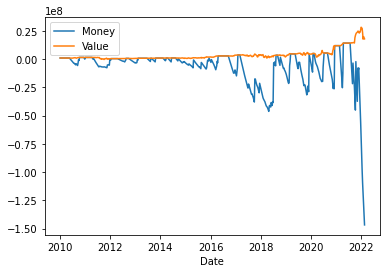

In [59]:
today = dt.date(2010, 1, 1)
simend = dt.date(2022, 2, 16)
data = yf.download(tickers_table,start=today,end=simend)

data['Adj Close'].to_csv('etfsprices.csv')
prices = pd.read_csv("etfsprices.csv", index_col="Date", parse_dates=True)

sma_30 = pd.DataFrame()
for i in tickers_table:
    sma_30[f'Adj_close_{i}'] = data['Adj Close'][f'{i}'].rolling(window=30).mean()

sma_100 = pd.DataFrame()
for i in tickers_table:
    sma_100[f'Adj_close_{i}'] = data['Adj Close'][f'{i}'].rolling(window=100).mean()

# Create a dataframe of all adj close prices
sma = pd.DataFrame(index=data.index)
#udata['Date'] = data.index
for i in tickers_table:
    sma[f'SMA_30_{i}'] = sma_30[f'Adj_close_{i}']
    sma[f'SMA_100_{i}']= sma_100[f'Adj_close_{i}']    
    
#prices.reset_index(inplace=True)
#df.reset_index(inplace=True)
#print(df.head(10))
# initilaizing the labels
tickers = []

transactionid = 0

money = 1000000

portfolio = {}

activelog = []

transactionlog = []

value= {'Date':[],
        'Money':[],
       'Value': []}

main()
volume = pd.DataFrame(value)
volume.plot(x = "Date",y = ["Money", 'Value'])
#making a data frame of the transaction loging and recording it
tranc_df = pd.DataFrame(transactionlog)
# saving in csv file
tranc_df.to_csv('rsi_transaction_2010-2022.csv',index=False)    

[*********************100%***********************]  11 of 11 completed
1000000.0 2019-01-02
1000000.0 2019-01-09
1000000.0 2019-01-16
1000000.0 2019-01-23
1000000.0 2019-01-30
1000000.0 2019-02-06
1000000.0 2019-02-13
1000000.0 2019-02-20
1000000.0 2019-02-27
1000000.0 2019-03-06
1000000.0 2019-03-13
1000000.0 2019-03-20
1000000.0 2019-03-27
1000000.0 2019-04-03
1000000.0 2019-04-10
1000000.0 2019-04-17
1000000.0 2019-04-24
1000000.0 2019-05-01
1000000.0 2019-05-08
1000000.0 2019-05-15
1000000.0 2019-05-22
1000000.0 2019-05-29
1012466.2 2019-06-05
1032676.15 2019-06-12
1060942.89 2019-06-19
1061391.66 2019-06-26
1072974.65 2019-07-03
1080873.09 2019-07-10
1056805.33 2019-07-17
1084030.97 2019-07-24
1056405.38 2019-07-31
856362.59 2019-08-07
782247.43 2019-08-14
870483.01 2019-08-21
775378.93 2019-08-28
868261.56 2019-09-04
1100848.45 2019-09-11
1163994.86 2019-09-18
1085321.91 2019-09-25
733019.08 2019-10-02
747171.6 2019-10-09
853667.59 2019-10-16
1035181.48 2019-10-23
978334.58 2019-

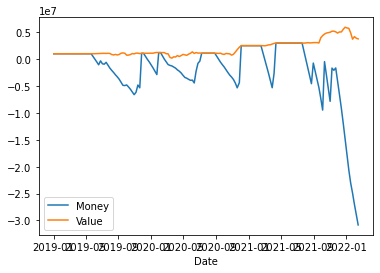

In [60]:
today = dt.date(2019, 1, 1)
simend = dt.date(2022, 2, 16)
data = yf.download(tickers_table,start=today,end=simend)

data['Adj Close'].to_csv('etfsprices.csv')
prices = pd.read_csv("etfsprices.csv", index_col="Date", parse_dates=True)

sma_30 = pd.DataFrame()
for i in tickers_table:
    sma_30[f'Adj_close_{i}'] = data['Adj Close'][f'{i}'].rolling(window=30).mean()

sma_100 = pd.DataFrame()
for i in tickers_table:
    sma_100[f'Adj_close_{i}'] = data['Adj Close'][f'{i}'].rolling(window=100).mean()

# Create a dataframe of all adj close prices
sma = pd.DataFrame(index=data.index)
for i in tickers_table:
    sma[f'SMA_30_{i}'] = sma_30[f'Adj_close_{i}']
    sma[f'SMA_100_{i}']= sma_100[f'Adj_close_{i}']    
    
#prices.reset_index(inplace=True)
#df.reset_index(inplace=True)
#print(df.head(10))
# initilaizing the labels
tickers = []

transactionid = 0

money = 1000000

portfolio = {}

activelog = []

transactionlog = []

value= {'Date':[],
        'Money':[],
       'Value': []}

main()
volume = pd.DataFrame(value)
volume.plot(x = "Date",y = ["Money", 'Value'])
#making a data frame of the transaction loging and recording it
tranc_df = pd.DataFrame(transactionlog)
# saving in csv file
tranc_df.to_csv('rsi_transaction_2010-2022.csv',index=False)    

[*********************100%***********************]  11 of 11 completed
1000000.0 2021-01-04
1000000.0 2021-01-11
1000000.0 2021-01-19
1000000.0 2021-01-26
1000000.0 2021-02-02
1000000.0 2021-02-09
1000000.0 2021-02-16
1000000.0 2021-02-23
1000000.0 2021-03-02
1000000.0 2021-03-09
1000000.0 2021-03-16
1000000.0 2021-03-23
1000000.0 2021-03-30
1000000.0 2021-04-06
1000000.0 2021-04-13
1000000.0 2021-04-20
1000000.0 2021-04-27
1000000.0 2021-05-04
1000000.0 2021-05-11
1000000.0 2021-05-18
1000000.0 2021-05-25
1000000.0 2021-06-01
1000000.0 2021-06-08
1000000.0 2021-06-15
1000000.0 2021-06-22
1000000.0 2021-06-29
1000000.0 2021-07-06
1000000.0 2021-07-13
1000000.0 2021-07-20
1000000.0 2021-07-27
1008056.72 2021-08-03
1025555.06 2021-08-10
1012766.5 2021-08-17
1016835.95 2021-08-24
1029037.93 2021-08-31
1027195.79 2021-09-07
1031628.89 2021-09-14
1006656.78 2021-09-21
1332390.5 2021-09-28
1467849.37 2021-10-05
1563863.66 2021-10-12
1626058.67 2021-10-19
1652282.63 2021-10-26
1677167.26 2021

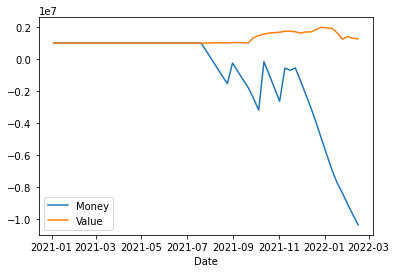

In [61]:
today = dt.date(2021, 1, 1)
simend = dt.date(2022, 2, 16)
data = yf.download(tickers_table,start=today,end=simend)

data['Adj Close'].to_csv('etfsprices.csv')
prices = pd.read_csv("etfsprices.csv", index_col="Date", parse_dates=True)

sma_30 = pd.DataFrame()
for i in tickers_table:
    sma_30[f'Adj_close_{i}'] = data['Adj Close'][f'{i}'].rolling(window=30).mean()

sma_100 = pd.DataFrame()
for i in tickers_table:
    sma_100[f'Adj_close_{i}'] = data['Adj Close'][f'{i}'].rolling(window=100).mean()

# Create a dataframe of all adj close prices
sma = pd.DataFrame(index=data.index)
#udata['Date'] = data.index
for i in tickers_table:
    sma[f'SMA_30_{i}'] = sma_30[f'Adj_close_{i}']
    sma[f'SMA_100_{i}']= sma_100[f'Adj_close_{i}']    
    
#prices.reset_index(inplace=True)
#df.reset_index(inplace=True)
#print(df.head(10))
# initilaizing the labels
tickers = []

transactionid = 0

money = 1000000

portfolio = {}

activelog = []

transactionlog = []

value= {'Date':[],
        'Money':[],
       'Value': []}

main()
volume = pd.DataFrame(value)
volume.plot(x = "Date",y = ["Money", 'Value'])
#making a data frame of the transaction loging and recording it
tranc_df = pd.DataFrame(transactionlog)
# saving in csv file
tranc_df.to_csv('rsi_transaction_2010-2022.csv',index=False)    

## RSI

In [62]:
#data = pd.read_csv("r1kdata.csv", index_col="Date", parse_dates=True)
#volumechanges = pd.read_csv("r1kvolume.csv", index_col="Date", parse_dates=True).pct_change()*100
#volumechanges.head()

#today = dt.date(2010, 1, 1)
#simend = dt.date(2022, 2, 25)
#tickers = []
#transactionid = 0
#money = 1000000
#portfolio = {}
#activelog = []
#transactionlog = []

def getprice(date, ticker):
    global prices
    try:
        price = prices.loc[str(date)][ticker]
        return price
    except Exception as e:
        return None


def transaction(id, ticker, amount, price, type,profit):
    #here we document everything
    global transactionid
    if type == "buy":
        #exp_date = today + dt.timedelta(days=14)
        transactionid += 1
    #else:
        #exp_date = today
        #create record of new transaction
    if type == "sell":
        data = {"id": id, "ticker": ticker, "amount": amount, "price": price, "date": today, "type": type,
                "profit": profit}
    elif type == "buy":
        data = {"id": transactionid, "ticker": ticker, "amount": amount, "price": price, "date": today, "type": type,
                "profit": profit}
        activelog.append(data)
    #append to tarsnaction log wich we create in the main
    transactionlog.append(data)


def buy(interestlst, allocated_money):
    #we receive the mean change which is probably a small number of stocks,
    #and how much money we have for this stock
    global money, portfolio
    for item in interestlst:
        #we do loop on all stocks in the interest list
        price = getprice(today, item)
        if not pd.isnull(price):
            #we look at the total allocation of money we have divided by price
            #hence how many shares we buy
            quantity = math.floor(allocated_money/price)
            money -= quantity*price
            #we update the number of shares per ticker
            portfolio[item] += quantity
            #we record the transaction
            transaction(0, item, quantity, price, "buy", 0)


def sell(interestlst_sma):
    global money, portfolio, prices, today
    #sell happens every 14 days so we check if 14 days passed since we bought
    itemstoremove = []
    for i in range(len(activelog)):
        #we go through all records in the log
        log = activelog[i]
        #check if log smaller than today
        #we should have sold it already - it means the date passed and we didnt sell yet
        #so if the date passed and the type is buy we sell
        if log["ticker"] in interestlst_sma and log["type"] == "buy":
            tickprice = getprice(today, log["ticker"])
            if not pd.isnull(tickprice):
                #we adjust the money amount
                money += log["amount"]*tickprice
                #we diduct the numbers of shares in portfolio
                portfolio[log["ticker"]] -= log["amount"]
                #calculate normalized profit
                profit = log["amount"]*tickprice - log["amount"]*log["price"]
                #we document the trasaction
                transaction(log["id"], log["ticker"], log["amount"], tickprice, "sell",profit)
                #we remove it fromt the active log 
                itemstoremove.append(i)
            '''else:
                log["exp_date"] += dt.timedelta(days=1)'''
    itemstoremove.reverse()
    for elem in itemstoremove:
        activelog.remove(activelog[elem])


def simulation():
    global today, rsi_data, money
    interestlstsell = []*0
    interestlstbuy = []*0
    #start_date = today - dt.timedelta(days=14)
    #get the average change in volume of the ticker in the two weeks range
    series = rsi_data.loc[today.strftime('%m-%d-%Y')]
    for j in tickers_table:
        if series[f'{j}'] <= 30:
            interestlstbuy.append(j)
        if series[f'{j}'] >= 70:
            interestlstsell.append(j)
            
    if len(interestlstbuy) > 0:
        moneyToAllocate = currentvalue()/(2*len(interestlstbuy))
        buy(interestlstbuy, moneyToAllocate)
    
    if len(interestlstsell) > 0:
        sell(interestlstsell)

def getindices():
    #get symbols of s&p500 and save them in tickers
    global tickers
    f = open("symbols2.txt", "r")
    for line in f:
        tickers.append(line.strip())
    f.close()


def tradingday():
    global prices, today
    return np.datetime64(today) in list(prices.index.values)


def currentvalue():
    #for each ticker get the price today
    global money, portfolio, today, prices
    value = money
    for ticker in tickers:
        tickprice = getprice(today, ticker)
        if not pd.isnull(tickprice):
            #if not null, update teh total value by teh price multiple by how 
            #many stocks we have. add it to total value of the portfolio.
            value += portfolio[ticker]*tickprice
            #return it converted as int
    return int(value*100)/100


def main():
    global today
    getindices()
    for ticker in tickers:
        #for each ticker how many shares we have
        portfolio[ticker] = 0
    while today < simend:
        while not tradingday():
            today += dt.timedelta(days=1)
        simulation()
        #calc curr value of the portfolio
        currentpvalue = currentvalue()
        print(currentpvalue, today)
        value['Date'].append(today)
        value['Money'].append(money)
        value['Value'].append(currentpvalue)
        #we look at trasaction every week. byt why? if we do it every day
        #its s little lower if we do every day! 1 million less.
        today += dt.timedelta(days=7)

    df = pd.DataFrame(transactionlog)
    df.to_csv('transactions.csv',index=False)

    

In [63]:
tickers_table = ['XLK','XLE','XLF','XLV','XLRE',
                 'XLB','XLY','XLP','XLU','XLI','IYZ']

[*********************100%***********************]  11 of 11 completed
1000000.0 2010-01-04
1000000.0 2010-01-11
1000000.0 2010-01-19
1000000.0 2010-01-26
1000537.64 2010-02-02
988441.06 2010-02-09
995430.26 2010-02-16
1001344.13 2010-02-23
1011290.3 2010-03-02
1029569.43 2010-03-09
1029569.43 2010-03-16
1029569.43 2010-03-23
1029569.43 2010-03-30
1029569.43 2010-04-06
1029569.43 2010-04-13
1029569.43 2010-04-20
1029569.43 2010-04-27
1029569.43 2010-05-04
1029569.43 2010-05-11
1029569.43 2010-05-18
1029569.43 2010-05-25
1028489.85 2010-06-01
1027769.98 2010-06-08
1049361.29 2010-06-15
1043036.3 2010-06-22
1028930.69 2010-06-29
1024228.71 2010-07-06
1081121.34 2010-07-13
1064333.62 2010-07-20
1082207.22 2010-07-27
1091063.96 2010-08-03
1108045.74 2010-08-10
1084362.8 2010-08-17
1043101.55 2010-08-24
1043241.98 2010-08-31
1087203.04 2010-09-07
1120954.46 2010-09-14
1142603.47 2010-09-21
1157265.6 2010-09-28
1164552.6 2010-10-05
1173097.87 2010-10-12
1167255.19 2010-10-19
1196845.37 2010-

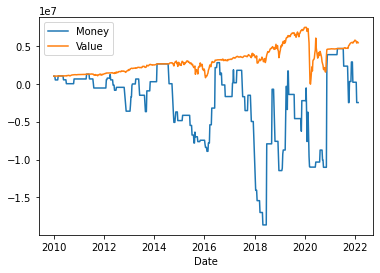

In [64]:
today = dt.date(2010, 1, 1)
simend = dt.date(2022, 2, 16)
data = yf.download(tickers_table,start=today,end=simend)

prices = data['Adj Close']
volumechanges=data['Volume'].pct_change()*100
rsi_data = data['Close']

for i in rsi_data.columns:
    rsi_data[i] = pta.rsi(data['Close'][i], length=14)  
    
#prices.reset_index(inplace=True)
#df.reset_index(inplace=True)
#print(df.head(10))
# initilaizing the labels
tickers = []

transactionid = 0

money = 1000000

portfolio = {}

activelog = []

transactionlog = []

value= {'Date':[],
        'Money':[],
       'Value': []}

main()
volume = pd.DataFrame(value)
volume.plot(x = "Date",y = ["Money", 'Value'])
#making a data frame of the transaction loging and recording it
tranc_df = pd.DataFrame(transactionlog)
# saving in csv file
tranc_df.to_csv('rsi_transaction_2010-2022.csv',index=False)    

[*********************100%***********************]  11 of 11 completed
1000000.0 2019-01-02
1000000.0 2019-01-09
1000000.0 2019-01-16
1000000.0 2019-01-23
1000000.0 2019-01-30
1000000.0 2019-02-06
1000000.0 2019-02-13
1000000.0 2019-02-20
1000000.0 2019-02-27
1000000.0 2019-03-06
1000000.0 2019-03-13
1000000.0 2019-03-20
1000000.0 2019-03-27
1000000.0 2019-04-03
1000000.0 2019-04-10
1000000.0 2019-04-17
1008451.63 2019-04-24
1019351.38 2019-05-01
1019176.43 2019-05-08
1012590.02 2019-05-15
1023081.66 2019-05-22
1009617.43 2019-05-29
1016409.01 2019-06-05
1034664.62 2019-06-12
1057902.68 2019-06-19
1072308.02 2019-06-26
1068524.99 2019-07-03
1077268.15 2019-07-10
1063985.21 2019-07-17
1072644.35 2019-07-24
1066002.86 2019-07-31
1027247.16 2019-08-07
1002064.69 2019-08-14
1041990.97 2019-08-21
1002586.75 2019-08-28
1037815.58 2019-09-04
1115579.91 2019-09-11
1140892.83 2019-09-18
1115650.24 2019-09-25
1009786.7 2019-10-02
1009786.7 2019-10-09
1032960.9 2019-10-16
1085629.37 2019-10-23
10

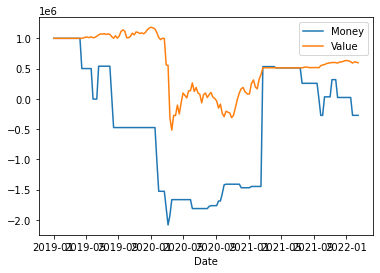

In [65]:
today = dt.date(2019, 1, 1)
simend = dt.date(2022, 2, 16)
data = yf.download(tickers_table,start=today,end=simend)

prices = data['Adj Close']
volumechanges=data['Volume'].pct_change()*100
rsi_data = data['Close']

for i in rsi_data.columns:
    rsi_data[i] = pta.rsi(data['Close'][i], length=14)  
    
#prices.reset_index(inplace=True)
#df.reset_index(inplace=True)
#print(df.head(10))
# initilaizing the labels
tickers = []

transactionid = 0

money = 1000000

portfolio = {}

activelog = []

transactionlog = []

value= {'Date':[],
        'Money':[],
       'Value': []}

main()
volume = pd.DataFrame(value)
volume.plot(x = "Date",y = ["Money", 'Value'])
#making a data frame of the transaction loging and recording it
tranc_df = pd.DataFrame(transactionlog)
# saving in csv file
tranc_df.to_csv('rsi_transaction_2010-2022.csv',index=False)    

[*********************100%***********************]  11 of 11 completed
1000000.0 2021-01-04
1000000.0 2021-01-11
1000000.0 2021-01-19
1000000.0 2021-01-26
1000000.0 2021-02-02
1000000.0 2021-02-09
1000000.0 2021-02-16
1000000.0 2021-02-23
1000000.0 2021-03-02
1000000.0 2021-03-09
1000000.0 2021-03-16
1000000.0 2021-03-23
1000000.0 2021-03-30
1000000.0 2021-04-06
1000000.0 2021-04-13
1000000.0 2021-04-20
1000000.0 2021-04-27
1000000.0 2021-05-04
1000000.0 2021-05-11
1000000.0 2021-05-18
1000000.0 2021-05-25
1000000.0 2021-06-01
1000000.0 2021-06-08
1000000.0 2021-06-15
1000000.0 2021-06-22
1000000.0 2021-06-29
1000000.0 2021-07-06
1000000.0 2021-07-13
1000000.0 2021-07-20
1017544.49 2021-07-27
1023847.94 2021-08-03
1021851.8 2021-08-10
1004412.41 2021-08-17
1008509.63 2021-08-24
1008509.63 2021-08-31
1007774.23 2021-09-07
1009034.9 2021-09-14
1003522.11 2021-09-21
1070725.53 2021-09-28
1095327.7 2021-10-05
1104424.4 2021-10-12
1137222.45 2021-10-19
1152024.03 2021-10-26
1160614.75 2021-

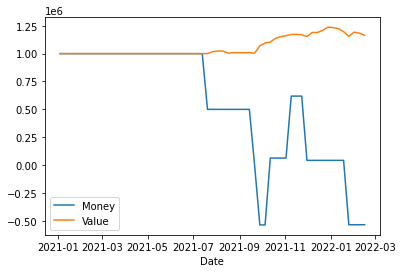

In [66]:
today = dt.date(2021, 1, 1)
simend = dt.date(2022, 2, 16)
data = yf.download(tickers_table,start=today,end=simend)

prices = data['Adj Close']
volumechanges=data['Volume'].pct_change()*100
rsi_data = data['Close']

for i in rsi_data.columns:
    rsi_data[i] = pta.rsi(data['Close'][i], length=14)  
    
#prices.reset_index(inplace=True)
#df.reset_index(inplace=True)
#print(df.head(10))
# initilaizing the labels
tickers = []

transactionid = 0

money = 1000000

portfolio = {}

activelog = []

transactionlog = []

value= {'Date':[],
        'Money':[],
       'Value': []}

main()
volume = pd.DataFrame(value)
volume.plot(x = "Date",y = ["Money", 'Value'])
#making a data frame of the transaction loging and recording it
tranc_df = pd.DataFrame(transactionlog)
# saving in csv file
tranc_df.to_csv('rsi_transaction_2010-2022.csv',index=False)    

## EMA

In [67]:
#data = pd.read_csv("r1kdata.csv", index_col="Date", parse_dates=True)
#volumechanges = pd.read_csv("r1kvolume.csv", index_col="Date", parse_dates=True).pct_change()*100
#volumechanges.head()

#today = dt.date(2010, 1, 1)
#simend = dt.date(2022, 2, 25)
#tickers = []
#transactionid = 0
#money = 1000000
#portfolio = {}
#activelog = []
#transactionlog = []

def getprice(date, ticker):
    global prices
    try:
        price = prices.loc[str(date)][ticker]
        return price
    except Exception as e:
        return None


def transaction(id, ticker, amount, price, type,profit):
    #here we document everything
    global transactionid
    if type == "buy":
        #exp_date = today + dt.timedelta(days=14)
        transactionid += 1
    #else:
        #exp_date = today
        #create record of new transaction
    if type == "sell":
        data = {"id": id, "ticker": ticker, "amount": amount, "price": price, "date": today, "type": type,
                "profit": profit}
    elif type == "buy":
        data = {"id": transactionid, "ticker": ticker, "amount": amount, "price": price, "date": today, "type": type,
                "profit": profit}
        activelog.append(data)
    #append to tarsnaction log wich we create in the main
    transactionlog.append(data)


def buy(interestlst, allocated_money):
    #we receive the mean change which is probably a small number of stocks,
    #and how much money we have for this stock
    global money, portfolio
    for item in interestlst:
        #we do loop on all stocks in the interest list
        price = getprice(today, item)
        if not pd.isnull(price):
            #we look at the total allocation of money we have divided by price
            #hence how many shares we buy
            quantity = math.floor(allocated_money/price)
            money -= quantity*price
            #we update the number of shares per ticker
            portfolio[item] += quantity
            #we record the transaction
            transaction(0, item, quantity, price, "buy", 0)


def sell(interestlst_sma):
    global money, portfolio, prices, today
    #sell happens every 14 days so we check if 14 days passed since we bought
    itemstoremove = []
    for i in range(len(activelog)):
        #we go through all records in the log
        log = activelog[i]
        #check if log smaller than today
        #we should have sold it already - it means the date passed and we didnt sell yet
        #so if the date passed and the type is buy we sell
        if log["ticker"] in interestlst_sma and log["type"] == "buy":
            tickprice = getprice(today, log["ticker"])
            if not pd.isnull(tickprice):
                #we adjust the money amount
                money += log["amount"]*tickprice
                #we diduct the numbers of shares in portfolio
                portfolio[log["ticker"]] -= log["amount"]
                #calculate normalized profit
                profit = log["amount"]*tickprice - log["amount"]*log["price"]
                #we document the trasaction
                transaction(log["id"], log["ticker"], log["amount"], tickprice, "sell",profit)
                #we remove it fromt the active log 
                itemstoremove.append(i)
            '''else:
                log["exp_date"] += dt.timedelta(days=1)'''
    itemstoremove.reverse()
    for elem in itemstoremove:
        activelog.remove(activelog[elem])


def simulation():
    global today, sma, money
    interestlstsell = []*0
    interestlstbuy = []*0
    #start_date = today - dt.timedelta(days=14)
    #get the average change in volume of the ticker in the two weeks range
    series = sma.loc[today.strftime('%m-%d-%Y')]
    for j in tickers_table:
        if series[f'SMA_30_{j}'] > series[f'SMA_100_{j}']:
            interestlstbuy.append(j)
        if series[f'SMA_30_{j}'] < series[f'SMA_100_{j}']:
            interestlstsell.append(j)
            
    if len(interestlstbuy) > 0:
        moneyToAllocate = currentvalue()/(2*len(interestlstbuy))
        buy(interestlstbuy, moneyToAllocate)
    
    if len(interestlstsell) > 0:
        sell(interestlstsell)

def getindices():
    #get symbols of s&p500 and save them in tickers
    global tickers
    f = open("symbols2.txt", "r")
    for line in f:
        tickers.append(line.strip())
    f.close()


def tradingday():
    global prices, today
    return np.datetime64(today) in list(prices.index.values)


def currentvalue():
    #for each ticker get the price today
    global money, portfolio, today, prices
    value = money
    for ticker in tickers:
        tickprice = getprice(today, ticker)
        if not pd.isnull(tickprice):
            #if not null, update teh total value by teh price multiple by how 
            #many stocks we have. add it to total value of the portfolio.
            value += portfolio[ticker]*tickprice
            #return it converted as int
    return int(value*100)/100


def main():
    global today
    getindices()
    for ticker in tickers:
        #for each ticker how many shares we have
        portfolio[ticker] = 0
    while today < simend:
        while not tradingday():
            today += dt.timedelta(days=1)
        simulation()
        #calc curr value of the portfolio
        currentpvalue = currentvalue()
        print(currentpvalue, today)
        value['Date'].append(today)
        value['Money'].append(money)
        value['Value'].append(currentpvalue)
        #we look at trasaction every week. byt why? if we do it every day
        #its s little lower if we do every day! 1 million less.
        today += dt.timedelta(days=7)

    df = pd.DataFrame(transactionlog)
    df.to_csv('transactions.csv',index=False)

    


In [68]:
tickers_table = ['XLK','XLE','XLF','XLV','XLRE',
                 'XLB','XLY','XLP','XLU','XLI','IYZ']

[*********************100%***********************]  11 of 11 completed
1000000.0 2010-01-04
1005607.98 2010-01-11
1007312.64 2010-01-19
935430.61 2010-01-26
948404.49 2010-02-02
948404.49 2010-02-09
948404.49 2010-02-16
948404.49 2010-02-23
954558.24 2010-03-02
966623.68 2010-03-09
992971.54 2010-03-16
1024034.71 2010-03-23
1024385.08 2010-03-30
1056209.57 2010-04-06
1076108.65 2010-04-13
1109337.34 2010-04-20
1027097.63 2010-04-27
990669.79 2010-05-04
915839.88 2010-05-11
783987.39 2010-05-18
552512.11 2010-05-25
547290.35 2010-06-01
489971.66 2010-06-08
564691.05 2010-06-15
492954.84 2010-06-22
486600.06 2010-06-29
486600.06 2010-07-06
486600.06 2010-07-13
486600.06 2010-07-20
492438.29 2010-07-27
490430.69 2010-08-03
496916.84 2010-08-10
487882.93 2010-08-17
460724.64 2010-08-24
469178.99 2010-08-31
502435.7 2010-09-07
518479.37 2010-09-14
537798.47 2010-09-21
565942.72 2010-09-28
593599.26 2010-10-05
589967.83 2010-10-12
582097.49 2010-10-19
621739.58 2010-10-26
643080.89 2010-11-0

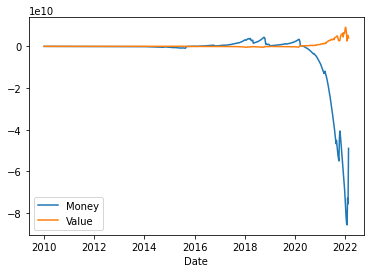

In [69]:
today = dt.date(2010, 1, 1)
simend = dt.date(2022, 2, 16)
data = yf.download(tickers_table,start=today,end=simend)

data['Adj Close'].to_csv('etfsprices.csv')
prices = pd.read_csv("etfsprices.csv", index_col="Date", parse_dates=True)

sma_30 = pd.DataFrame()
for i in tickers_table:
    sma_30[f'Adj_close_{i}'] = data['Adj Close'][f'{i}'].ewm(span=30).mean()

sma_100 = pd.DataFrame()
for i in tickers_table:
    sma_100[f'Adj_close_{i}'] = data['Adj Close'][f'{i}'].ewm(span=100).mean()

# Create a dataframe of all adj close prices
sma = pd.DataFrame(index=data.index)
#udata['Date'] = data.index
for i in tickers_table:
    sma[f'SMA_30_{i}'] = sma_30[f'Adj_close_{i}']
    sma[f'SMA_100_{i}']= sma_100[f'Adj_close_{i}']    
    
#prices.reset_index(inplace=True)
#df.reset_index(inplace=True)
#print(df.head(10))
# initilaizing the labels
tickers = []

transactionid = 0

money = 1000000

portfolio = {}

activelog = []

transactionlog = []

value= {'Date':[],
        'Money':[],
       'Value': []}

main()
volume = pd.DataFrame(value)
volume.plot(x = "Date",y = ["Money", 'Value'])
#making a data frame of the transaction loging and recording it
tranc_df = pd.DataFrame(transactionlog)
# saving in csv file
tranc_df.to_csv('rsi_transaction_2010-2022.csv',index=False)   

[*********************100%***********************]  11 of 11 completed
1000000.0 2019-01-02
1017906.21 2019-01-09
1026923.39 2019-01-16
1042896.59 2019-01-23
1079637.36 2019-01-30
1115990.02 2019-02-06
1154060.29 2019-02-13
1219407.38 2019-02-20
1223814.26 2019-02-27
1176183.84 2019-03-06
1255604.57 2019-03-13
1272250.44 2019-03-20
1263212.53 2019-03-27
1420140.18 2019-04-03
1474206.9 2019-04-10
1489167.28 2019-04-17
1554375.6 2019-04-24
1470393.69 2019-05-01
1286218.79 2019-05-08
1244323.8 2019-05-15
1281305.48 2019-05-22
1018453.47 2019-05-29
1266696.4 2019-06-05
1414643.95 2019-06-12
1558036.65 2019-06-19
1436818.46 2019-06-26
1805584.56 2019-07-03
1793150.63 2019-07-10
1774345.92 2019-07-17
1904625.03 2019-07-24
1721981.19 2019-07-31
1344368.11 2019-08-07
1127332.17 2019-08-14
1648664.98 2019-08-21
1521155.06 2019-08-28
1817876.99 2019-09-04
1820118.46 2019-09-11
1878433.67 2019-09-18
1889197.52 2019-09-25
1515881.99 2019-10-02
1709367.78 2019-10-09
1908899.41 2019-10-16
2040942.89

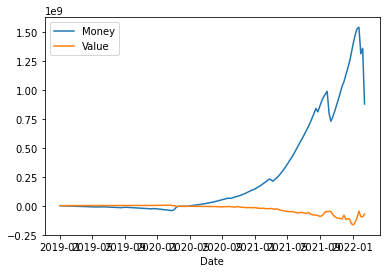

In [70]:
today = dt.date(2019, 1, 1)
simend = dt.date(2022, 2, 16)
data = yf.download(tickers_table,start=today,end=simend)

data['Adj Close'].to_csv('etfsprices.csv')
prices = pd.read_csv("etfsprices.csv", index_col="Date", parse_dates=True)

sma_30 = pd.DataFrame()
for i in tickers_table:
    sma_30[f'Adj_close_{i}'] = data['Adj Close'][f'{i}'].ewm(span=30).mean()

sma_100 = pd.DataFrame()
for i in tickers_table:
    sma_100[f'Adj_close_{i}'] = data['Adj Close'][f'{i}'].ewm(span=100).mean()

# Create a dataframe of all adj close prices
sma = pd.DataFrame(index=data.index)
#udata['Date'] = data.index
for i in tickers_table:
    sma[f'SMA_30_{i}'] = sma_30[f'Adj_close_{i}']
    sma[f'SMA_100_{i}']= sma_100[f'Adj_close_{i}']     
    
#prices.reset_index(inplace=True)
#df.reset_index(inplace=True)
#print(df.head(10))
# initilaizing the labels
tickers = []

transactionid = 0

money = 1000000

portfolio = {}

activelog = []

transactionlog = []

value= {'Date':[],
        'Money':[],
       'Value': []}

main()
volume = pd.DataFrame(value)
volume.plot(x = "Date",y = ["Money", 'Value'])
#making a data frame of the transaction loging and recording it
tranc_df = pd.DataFrame(transactionlog)
# saving in csv file
tranc_df.to_csv('rsi_transaction_2010-2022.csv',index=False)    

[*********************100%***********************]  11 of 11 completed
1000000.0 2021-01-04
1054135.21 2021-01-11
1077304.63 2021-01-19
1030160.43 2021-01-26
1006734.68 2021-02-02
1025700.68 2021-02-09
1019619.43 2021-02-16
999536.34 2021-02-23
979573.82 2021-03-02
1014404.1 2021-03-09
1068857.5 2021-03-16
1003979.63 2021-03-23
1106599.42 2021-03-30
1154237.65 2021-04-06
1151401.2 2021-04-13
1170544.44 2021-04-20
1257233.83 2021-04-27
1342669.19 2021-05-04
1418432.08 2021-05-11
1392385.09 2021-05-18
1404021.49 2021-05-25
1552507.79 2021-06-01
1654026.57 2021-06-08
1629517.99 2021-06-15
1479047.77 2021-06-22
1492277.01 2021-06-29
1564904.95 2021-07-06
1624105.94 2021-07-13
1426809.6 2021-07-20
1693217.41 2021-07-27
1827695.82 2021-08-03
1880727.75 2021-08-10
1978909.52 2021-08-17
2023729.44 2021-08-24
2162430.99 2021-08-31
2108199.5 2021-09-07
1766173.35 2021-09-14
1309828.78 2021-09-21
1252836.37 2021-09-28
1254501.47 2021-10-05
1251888.8 2021-10-12
1719533.35 2021-10-19
2083387.52 202

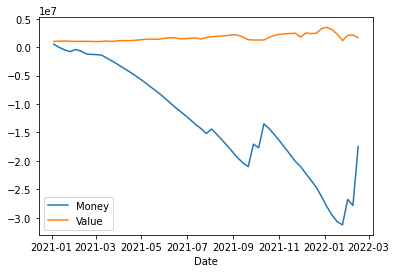

In [71]:
today = dt.date(2021, 1, 1)
simend = dt.date(2022, 2, 16)
data = yf.download(tickers_table,start=today,end=simend)

data['Adj Close'].to_csv('etfsprices.csv')
prices = pd.read_csv("etfsprices.csv", index_col="Date", parse_dates=True)

sma_30 = pd.DataFrame()
for i in tickers_table:
    sma_30[f'Adj_close_{i}'] = data['Adj Close'][f'{i}'].ewm(span=30).mean()

sma_100 = pd.DataFrame()
for i in tickers_table:
    sma_100[f'Adj_close_{i}'] = data['Adj Close'][f'{i}'].ewm(span=100).mean()

# Create a dataframe of all adj close prices
sma = pd.DataFrame(index=data.index)
#udata['Date'] = data.index
for i in tickers_table:
    sma[f'SMA_30_{i}'] = sma_30[f'Adj_close_{i}']
    sma[f'SMA_100_{i}']= sma_100[f'Adj_close_{i}']    
    
#prices.reset_index(inplace=True)
#df.reset_index(inplace=True)
#print(df.head(10))
# initilaizing the labels
tickers = []

transactionid = 0

money = 1000000

portfolio = {}

activelog = []

transactionlog = []

value= {'Date':[],
        'Money':[],
       'Value': []}

main()
volume = pd.DataFrame(value)
volume.plot(x = "Date",y = ["Money", 'Value'])
#making a data frame of the transaction loging and recording it
tranc_df = pd.DataFrame(transactionlog)
# saving in csv file
tranc_df.to_csv('rsi_transaction_2010-2022.csv',index=False)    

## Bollinger Bands 

In [72]:
#data = pd.read_csv("r1kdata.csv", index_col="Date", parse_dates=True)
#volumechanges = pd.read_csv("r1kvolume.csv", index_col="Date", parse_dates=True).pct_change()*100
#volumechanges.head()

#today = dt.date(2010, 1, 1)
#simend = dt.date(2022, 2, 25)
#tickers = []
#transactionid = 0
#money = 1000000
#portfolio = {}
#activelog = []
#transactionlog = []

def getprice(date, ticker):
    global prices
    try:
        price = prices.loc[str(date)][ticker]
        return price
    except Exception as e:
        return None


def transaction(id, ticker, amount, price, type,profit):
    #here we document everything
    global transactionid
    if type == "buy":
        #exp_date = today + dt.timedelta(days=14)
        transactionid += 1
    #else:
        #exp_date = today
        #create record of new transaction
    if type == "sell":
        data = {"id": id, "ticker": ticker, "amount": amount, "price": price, "date": today, "type": type,
                "profit": profit}
    elif type == "buy":
        data = {"id": transactionid, "ticker": ticker, "amount": amount, "price": price, "date": today, "type": type,
                "profit": profit}
        activelog.append(data)
    #append to tarsnaction log wich we create in the main
    transactionlog.append(data)


def buy(interestlst, allocated_money):
    #we receive the mean change which is probably a small number of stocks,
    #and how much money we have for this stock
    global money, portfolio
    for item in interestlst:
        #we do loop on all stocks in the interest list
        price = getprice(today, item)
        if not pd.isnull(price):
            #we look at the total allocation of money we have divided by price
            #hence how many shares we buy
            quantity = math.floor(allocated_money/price)
            money -= quantity*price
            #we update the number of shares per ticker
            portfolio[item] += quantity
            #we record the transaction
            transaction(0, item, quantity, price, "buy", 0)


def sell(interestlst_sma):
    global money, portfolio, prices, today
    #sell happens every 14 days so we check if 14 days passed since we bought
    itemstoremove = []
    for i in range(len(activelog)):
        #we go through all records in the log
        log = activelog[i]
        #check if log smaller than today
        #we should have sold it already - it means the date passed and we didnt sell yet
        #so if the date passed and the type is buy we sell
        if log["ticker"] in interestlst_sma and log["type"] == "buy":
            tickprice = getprice(today, log["ticker"])
            if not pd.isnull(tickprice):
                #we adjust the money amount
                money += log["amount"]*tickprice
                #we diduct the numbers of shares in portfolio
                portfolio[log["ticker"]] -= log["amount"]
                #calculate normalized profit
                profit = log["amount"]*tickprice - log["amount"]*log["price"]
                #we document the trasaction
                transaction(log["id"], log["ticker"], log["amount"], tickprice, "sell",profit)
                #we remove it fromt the active log 
                itemstoremove.append(i)
            '''else:
                log["exp_date"] += dt.timedelta(days=1)'''
    itemstoremove.reverse()
    for elem in itemstoremove:
        activelog.remove(activelog[elem])


def simulation():
    global today, bollinger, money
    interestlstsell = []*0
    interestlstbuy = []*0
    #start_date = today - dt.timedelta(days=14)
    #get the average change in volume of the ticker in the two weeks range
    series = bollinger.loc[today.strftime('%m-%d-%Y')]
    for j in tickers_table:
        if series[f'Close_{j}'] < series[f'LowerBand_{j}']:
            interestlstbuy.append(j)
        if series[f'Close_{j}'] > series[f'UpperBand_{j}']:
            interestlstsell.append(j)
    
    if len(interestlstbuy) > 0:
        moneyToAllocate = currentvalue()/(2*len(interestlstbuy))
        buy(interestlstbuy, moneyToAllocate)
    
    if len(interestlstsell) > 0:
        sell(interestlstsell)

def getindices():
    #get symbols of s&p500 and save them in tickers
    global tickers
    f = open("symbols2.txt", "r")
    for line in f:
        tickers.append(line.strip())
    f.close()


def tradingday():
    global prices, today
    return np.datetime64(today) in list(prices.index.values)


def currentvalue():
    #for each ticker get the price today
    global money, portfolio, today, prices
    value = money
    for ticker in tickers:
        tickprice = getprice(today, ticker)
        if not pd.isnull(tickprice):
            #if not null, update teh total value by teh price multiple by how 
            #many stocks we have. add it to total value of the portfolio.
            value += portfolio[ticker]*tickprice
            #return it converted as int
    return int(value*100)/100


def main():
    global today
    getindices()
    for ticker in tickers:
        #for each ticker how many shares we have
        portfolio[ticker] = 0
    while today < simend:
        while not tradingday():
            today += dt.timedelta(days=1)
        simulation()
        #calc curr value of the portfolio
        currentpvalue = currentvalue()
        print(currentpvalue, today)
        value['Date'].append(today)
        value['Money'].append(money)
        value['Value'].append(currentpvalue)
        #we look at trasaction every week. byt why? if we do it every day
        #its s little lower if we do every day! 1 million less.
        today += dt.timedelta(days=7)

    df = pd.DataFrame(transactionlog)
    df.to_csv('transactions.csv',index=False)

    


In [73]:
tickers_table = ['XLK','XLE','XLF','XLV','XLRE',
                 'XLB','XLY','XLP','XLU','XLI','IYZ']

[*********************100%***********************]  11 of 11 completed
1000000.0 2010-01-04
1000000.0 2010-01-11
1000000.0 2010-01-19
1000000.0 2010-01-26
1000000.0 2010-02-02
1000000.0 2010-02-09
1000000.0 2010-02-16
1000000.0 2010-02-23
1000000.0 2010-03-02
1000000.0 2010-03-09
1000000.0 2010-03-16
1000000.0 2010-03-23
1000000.0 2010-03-30
1000000.0 2010-04-06
1000000.0 2010-04-13
1000000.0 2010-04-20
1000000.0 2010-04-27
1001821.99 2010-05-04
989459.63 2010-05-11
969156.06 2010-05-18
933572.71 2010-05-25
934466.49 2010-06-01
927123.61 2010-06-08
979626.82 2010-06-15
950757.52 2010-06-22
900915.19 2010-06-29
883770.03 2010-07-06
990631.24 2010-07-13
983322.19 2010-07-20
1028173.31 2010-07-27
1022688.04 2010-08-03
1035908.45 2010-08-10
1002902.86 2010-08-17
946667.83 2010-08-24
945966.52 2010-08-31
1037936.91 2010-09-07
1099258.33 2010-09-14
1124941.96 2010-09-21
1154328.51 2010-09-28
1171200.51 2010-10-05
1196220.59 2010-10-12
1193964.8 2010-10-19
1248133.83 2010-10-26
1267911.79 201

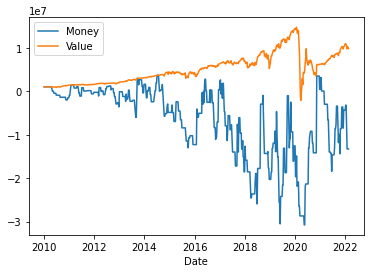

In [74]:
today = dt.date(2010, 1, 1)
simend = dt.date(2022, 2, 16)
data = yf.download(tickers_table,start=today,end=simend)
data['Close'].to_csv('etfsprices.csv')
prices = pd.read_csv("etfsprices.csv", index_col="Date", parse_dates=True)


#20 days rolling period
period = 20
multiplier = 2

bollinger = pd.DataFrame()
for i in tickers_table:
    bollinger[f'UpperBand_{i}'] = data['Close'][f'{i}'].rolling(period).mean() + data['Close'][f'{i}'].rolling(period).std() * multiplier

for i in tickers_table:
    bollinger[f'LowerBand_{i}'] = data['Close'][f'{i}'].rolling(period).mean() - data['Close'][f'{i}'].rolling(period).std() * multiplier

for i in tickers_table:
    bollinger[f'Close_{i}'] = data['Close'][f'{i}']

#prices.reset_index(inplace=True)
#df.reset_index(inplace=True)
#print(df.head(10))
# initilaizing the labels
tickers = []

transactionid = 0

money = 1000000

portfolio = {}

activelog = []

transactionlog = []

value= {'Date':[],
        'Money':[],
       'Value': []}

main()
volume = pd.DataFrame(value)
volume.plot(x = "Date",y = ["Money", 'Value'])
#making a data frame of the transaction loging and recording it
tranc_df = pd.DataFrame(transactionlog)
# saving in csv file
tranc_df.to_csv('rsi_transaction_2010-2022.csv',index=False)    

[*********************100%***********************]  11 of 11 completed
1000000.0 2019-01-02
1000000.0 2019-01-09
1000000.0 2019-01-16
1000000.0 2019-01-23
1000000.0 2019-01-30
1000000.0 2019-02-06
1000000.0 2019-02-13
1000000.0 2019-02-20
1000000.0 2019-02-27
1000000.0 2019-03-06
1000000.0 2019-03-13
1000000.0 2019-03-20
1000000.0 2019-03-27
1000000.0 2019-04-03
1000000.0 2019-04-10
1000000.0 2019-04-17
1008054.99 2019-04-24
1015206.23 2019-05-01
1000745.34 2019-05-08
995482.57 2019-05-15
1005118.96 2019-05-22
967475.54 2019-05-29
1013767.34 2019-06-05
1035059.05 2019-06-12
1054406.09 2019-06-19
1051448.75 2019-06-26
1070085.12 2019-07-03
1075570.28 2019-07-10
1059403.98 2019-07-17
1067520.12 2019-07-24
1058213.08 2019-07-31
1003053.75 2019-08-07
964835.09 2019-08-14
1027812.64 2019-08-21
991574.17 2019-08-28
1028414.12 2019-09-04
1106266.69 2019-09-11
1104897.65 2019-09-18
1088883.51 2019-09-25
1058344.7 2019-10-02
1070214.94 2019-10-09
1116473.08 2019-10-16
1122454.86 2019-10-23
1145

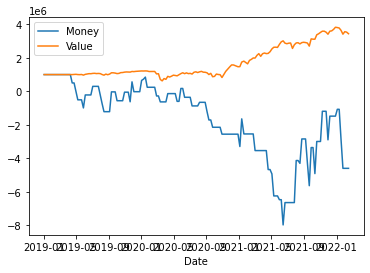

In [75]:
today = dt.date(2019, 1, 1)
simend = dt.date(2022, 2, 16)
data = yf.download(tickers_table,start=today,end=simend)
data['Close'].to_csv('etfsprices.csv')
prices = pd.read_csv("etfsprices.csv", index_col="Date", parse_dates=True)


#20 days rolling period
period = 20
multiplier = 2

bollinger = pd.DataFrame()
for i in tickers_table:
    bollinger[f'UpperBand_{i}'] = data['Close'][f'{i}'].rolling(period).mean() + data['Close'][f'{i}'].rolling(period).std() * multiplier

for i in tickers_table:
    bollinger[f'LowerBand_{i}'] = data['Close'][f'{i}'].rolling(period).mean() - data['Close'][f'{i}'].rolling(period).std() * multiplier

for i in tickers_table:
    bollinger[f'Close_{i}'] = data['Close'][f'{i}']

#prices.reset_index(inplace=True)
#df.reset_index(inplace=True)
#print(df.head(10))
# initilaizing the labels
tickers = []

transactionid = 0

money = 1000000

portfolio = {}

activelog = []

transactionlog = []

value= {'Date':[],
        'Money':[],
       'Value': []}

main()
volume = pd.DataFrame(value)
volume.plot(x = "Date",y = ["Money", 'Value'])
#making a data frame of the transaction loging and recording it
tranc_df = pd.DataFrame(transactionlog)
# saving in csv file
tranc_df.to_csv('rsi_transaction_2010-2022.csv',index=False)    

[*********************100%***********************]  11 of 11 completed
1000000.0 2021-01-04
1000000.0 2021-01-11
1000000.0 2021-01-19
1000000.0 2021-01-26
1000000.0 2021-02-02
1000000.0 2021-02-09
1000000.0 2021-02-16
1000000.0 2021-02-23
1000000.0 2021-03-02
1003902.78 2021-03-09
1031222.55 2021-03-16
1022205.66 2021-03-23
1033645.0 2021-03-30
1044142.22 2021-04-06
1049390.83 2021-04-13
1065136.72 2021-04-20
1085212.61 2021-04-27
1111014.43 2021-05-04
1118009.59 2021-05-11
1115442.4 2021-05-18
1130883.33 2021-05-25
1176841.77 2021-06-01
1208607.59 2021-06-08
1233257.3 2021-06-15
1213529.76 2021-06-22
1215354.48 2021-06-29
1229718.3 2021-07-06
1239083.9 2021-07-13
1162504.26 2021-07-20
1220026.33 2021-07-27
1254108.08 2021-08-03
1260136.37 2021-08-10
1243990.19 2021-08-17
1272168.49 2021-08-24
1280733.77 2021-08-31
1274399.61 2021-09-07
1261569.34 2021-09-14
1198431.47 2021-09-21
1308606.88 2021-09-28
1301045.74 2021-10-05
1300086.99 2021-10-12
1412799.99 2021-10-19
1438874.39 2021-10-

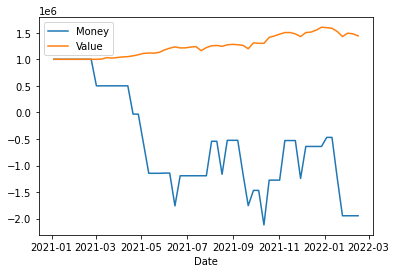

In [76]:
today = dt.date(2021, 1, 1)
simend = dt.date(2022, 2, 16)
data = yf.download(tickers_table,start=today,end=simend)
data['Close'].to_csv('etfsprices.csv')
prices = pd.read_csv("etfsprices.csv", index_col="Date", parse_dates=True)


#20 days rolling period
period = 20
multiplier = 2

bollinger = pd.DataFrame()
for i in tickers_table:
    bollinger[f'UpperBand_{i}'] = data['Close'][f'{i}'].rolling(period).mean() + data['Close'][f'{i}'].rolling(period).std() * multiplier

for i in tickers_table:
    bollinger[f'LowerBand_{i}'] = data['Close'][f'{i}'].rolling(period).mean() - data['Close'][f'{i}'].rolling(period).std() * multiplier

for i in tickers_table:
    bollinger[f'Close_{i}'] = data['Close'][f'{i}']

#prices.reset_index(inplace=True)
#df.reset_index(inplace=True)
#print(df.head(10))
# initilaizing the labels
tickers = []

transactionid = 0

money = 1000000

portfolio = {}

activelog = []

transactionlog = []

value= {'Date':[],
        'Money':[],
       'Value': []}

main()
volume = pd.DataFrame(value)
volume.plot(x = "Date",y = ["Money", 'Value'])
#making a data frame of the transaction loging and recording it
tranc_df = pd.DataFrame(transactionlog)
# saving in csv file
tranc_df.to_csv('rsi_transaction_2010-2022.csv',index=False)   

## Volume Change

In [77]:
#data = pd.read_csv("r1kdata.csv", index_col="Date", parse_dates=True)
#volumechanges = pd.read_csv("r1kvolume.csv", index_col="Date", parse_dates=True).pct_change()*100
#volumechanges.head()

#today = dt.date(2010, 1, 1)
#simend = dt.date(2022, 2, 25)
#tickers = []
#transactionid = 0
#money = 1000000
#portfolio = {}
#activelog = []
#transactionlog = []

def getprice(date, ticker):
    global prices
    try:
        price = prices.loc[str(date)][ticker]
        return price
    except Exception as e:
        return None


def transaction(id, ticker, amount, price, type,profit):
    global transactionid
    if type == "buy":
        exp_date = today + dt.timedelta(days=14)
        transactionid += 1
    else:
        exp_date = today
    if type == "sell":
        data = {"id": id, "ticker": ticker, "amount": amount, "price": price, "date": today, "type": type,
                "exp_date": exp_date, "profit": profit}
    elif type == "buy":
        data = {"id": transactionid, "ticker": ticker, "amount": amount, "price": price, "date": today, "type": type,
                "exp_date": exp_date, "profit": profit}
        activelog.append(data)
    transactionlog.append(data)


def buy(interestlst, allocated_money):
    #we receive the mean change which is probably a small number of stocks,
    #and how much money we have for this stock
    global money, portfolio
    for item in interestlst:
        #we do loop on all stocks in the interest list
        price = getprice(today, item)
        if not pd.isnull(price):
            #we look at the total allocation of money we have divided by price
            #hence how many shares we buy
            quantity = math.floor(allocated_money/price)
            money -= quantity*price
            #we update the number of shares per ticker
            portfolio[item] += quantity
            #we record the transaction
            transaction(0, item, quantity, price, "buy", 0)


def sell():
    global money, portfolio, prices, today
    itemstoremove = []
    for i in range(len(activelog)):
        log = activelog[i]
        if log["exp_date"] <= today and log["type"] == "buy":
            tickprice = getprice(today, log["ticker"])
            if not pd.isnull(tickprice):
                money += log["amount"]*tickprice
                portfolio[log["ticker"]] -= log["amount"]
                profit = log["amount"]*tickprice - log["amount"]*log["price"]
                transaction(log["id"], log["ticker"], log["amount"], tickprice, "sell",profit)
                itemstoremove.append(i)
            else:
                log["exp_date"] += dt.timedelta(days=1)
    itemstoremove.reverse()
    for elem in itemstoremove:
        activelog.remove(activelog[elem])


def simulation():
    global today, volumechanges, money
    interestlstbuy = []*0
    start_date = today - dt.timedelta(days=14)
    #get the average change in volume of the ticker in the two weeks range
    series = volumechanges.loc[start_date:today].mean()
    for j in tickers_table:
        if series[f'{j}'] > 80:
            interestlstbuy.append(j)
    sell()
    
    if len(interestlstbuy) > 0:
        moneyToAllocate = currentvalue()/(2*len(interestlstbuy))
        buy(interestlstbuy, moneyToAllocate)

def getindices():
    #get symbols of s&p500 and save them in tickers
    global tickers
    f = open("symbols2.txt", "r")
    for line in f:
        tickers.append(line.strip())
    f.close()


def tradingday():
    global prices, today
    return np.datetime64(today) in list(prices.index.values)


def currentvalue():
    #for each ticker get the price today
    global money, portfolio, today, prices
    value = money
    for ticker in tickers:
        tickprice = getprice(today, ticker)
        if not pd.isnull(tickprice):
            #if not null, update teh total value by teh price multiple by how 
            #many stocks we have. add it to total value of the portfolio.
            value += portfolio[ticker]*tickprice
            #return it converted as int
    return int(value*100)/100


def main():
    global today
    getindices()
    for ticker in tickers:
        #for each ticker how many shares we have
        portfolio[ticker] = 0
    while today < simend:
        while not tradingday():
            today += dt.timedelta(days=1)
        simulation()
        #calc curr value of the portfolio
        currentpvalue = currentvalue()
        print(currentpvalue, today)
        value['Date'].append(today)
        value['Money'].append(money)
        value['Value'].append(currentpvalue)
        #we look at trasaction every week. byt why? if we do it every day
        #its s little lower if we do every day! 1 million less.
        today += dt.timedelta(days=1)

    df = pd.DataFrame(transactionlog)
    df.to_csv('transactions.csv',index=False)

    

In [78]:
tickers_table = ['XLK','XLE','XLF','XLV','XLRE',
                 'XLB','XLY','XLP','XLU','XLI','IYZ']

[*********************100%***********************]  11 of 11 completed
1000000.0 2010-01-04
1003696.85 2010-01-05
1009663.81 2010-01-06
1011863.82 2010-01-07
1017503.62 2010-01-08
1017570.08 2010-01-11
1004289.05 2010-01-12
1013295.71 2010-01-13
1011680.98 2010-01-14
1001095.68 2010-01-15
1014052.64 2010-01-19
1014052.64 2010-01-20
1014052.64 2010-01-21
1014052.64 2010-01-22
1014052.64 2010-01-25
1014052.64 2010-01-26
1014052.64 2010-01-27
1014052.64 2010-01-28
1014052.64 2010-01-29
1014052.64 2010-02-01
1014052.64 2010-02-02
1014052.64 2010-02-03
1014052.64 2010-02-04
1014052.64 2010-02-05
1014052.64 2010-02-08
1014052.64 2010-02-09
1014052.64 2010-02-10
1014052.64 2010-02-11
1014052.64 2010-02-12
1014052.64 2010-02-16
1014052.64 2010-02-17
1014052.64 2010-02-18
1014052.64 2010-02-19
1014052.64 2010-02-22
1014052.64 2010-02-23
1014052.64 2010-02-24
1014052.64 2010-02-25
1014052.64 2010-02-26
1014052.64 2010-03-01
1014052.64 2010-03-02
1014052.64 2010-03-03
1014052.64 2010-03-04
101405

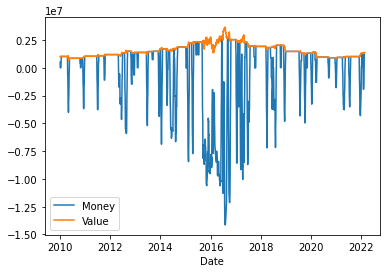

In [79]:
today = dt.date(2010, 1, 1)
simend = dt.date(2022, 2, 16)
data = yf.download(tickers_table,start=today,end=simend)
data['Adj Close'].to_csv('etfsprices.csv')
prices = pd.read_csv("etfsprices.csv", index_col="Date", parse_dates=True)
data['Volume'].to_csv('etfsvolume.csv')
volumechanges = pd.read_csv("etfsvolume.csv", index_col="Date", parse_dates=True).pct_change()*100

#prices.reset_index(inplace=True)
#df.reset_index(inplace=True)
#print(df.head(10))
# initilaizing the labels
tickers = []

transactionid = 0

money = 1000000

portfolio = {}

activelog = []

transactionlog = []

value= {'Date':[],
        'Money':[],
       'Value': []}

main()
volume = pd.DataFrame(value)
volume.plot(x = "Date",y = ["Money", 'Value'])
#making a data frame of the transaction loging and recording it
tranc_df = pd.DataFrame(transactionlog)
# saving in csv file
tranc_df.to_csv('rsi_transaction_2010-2022.csv',index=False)    

[*********************100%***********************]  11 of 11 completed
1000000.0 2019-01-02
1000000.0 2019-01-03
1000000.0 2019-01-04
1000000.0 2019-01-07
1000000.0 2019-01-08
1000000.0 2019-01-09
1000000.0 2019-01-10
1000000.0 2019-01-11
1000000.0 2019-01-14
1000000.0 2019-01-15
1000000.0 2019-01-16
1000000.0 2019-01-17
1000000.0 2019-01-18
1000000.0 2019-01-22
1000000.0 2019-01-23
1000000.0 2019-01-24
1000000.0 2019-01-25
1000000.0 2019-01-28
1000000.0 2019-01-29
1000000.0 2019-01-30
1000000.0 2019-01-31
1000000.0 2019-02-01
1000000.0 2019-02-04
1000000.0 2019-02-05
1000000.0 2019-02-06
1000000.0 2019-02-07
1000000.0 2019-02-08
1000000.0 2019-02-11
1000000.0 2019-02-12
1000000.0 2019-02-13
1000000.0 2019-02-14
1000000.0 2019-02-15
1000000.0 2019-02-19
1000000.0 2019-02-20
1000000.0 2019-02-21
1000000.0 2019-02-22
1000000.0 2019-02-25
1000000.0 2019-02-26
1000000.0 2019-02-27
1000000.0 2019-02-28
1000000.0 2019-03-01
1000000.0 2019-03-04
1000000.0 2019-03-05
1000000.0 2019-03-06
10000

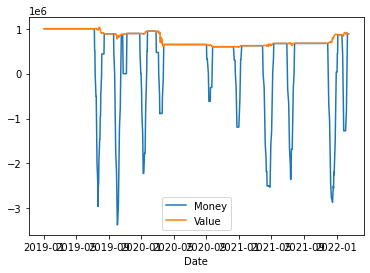

In [80]:
today = dt.date(2019, 1, 1)
simend = dt.date(2022, 2, 16)
data = yf.download(tickers_table,start=today,end=simend)
data['Close'].to_csv('etfsprices.csv')
prices = pd.read_csv("etfsprices.csv", index_col="Date", parse_dates=True)
data['Volume'].to_csv('etfsvolume.csv')
volumechanges = pd.read_csv("etfsvolume.csv", index_col="Date", parse_dates=True).pct_change()*100

#prices.reset_index(inplace=True)
#df.reset_index(inplace=True)
#print(df.head(10))
# initilaizing the labels
tickers = []

transactionid = 0

money = 1000000

portfolio = {}

activelog = []

transactionlog = []

value= {'Date':[],
        'Money':[],
       'Value': []}

main()
volume = pd.DataFrame(value)
volume.plot(x = "Date",y = ["Money", 'Value'])
#making a data frame of the transaction loging and recording it
tranc_df = pd.DataFrame(transactionlog)
# saving in csv file
tranc_df.to_csv('rsi_transaction_2010-2022.csv',index=False)    

[*********************100%***********************]  11 of 11 completed
1000000.0 2021-01-04
1007017.85 2021-01-05
1035139.32 2021-01-06
1050860.0 2021-01-07
1048953.66 2021-01-08
1048723.8 2021-01-11
1065599.37 2021-01-12
1056016.74 2021-01-13
1055218.08 2021-01-14
1032984.81 2021-01-15
1040040.31 2021-01-19
1039785.13 2021-01-20
1039785.13 2021-01-21
1039785.13 2021-01-22
1039785.13 2021-01-25
1039785.13 2021-01-26
1039785.13 2021-01-27
1039785.13 2021-01-28
1039785.13 2021-01-29
1039785.13 2021-02-01
1039785.13 2021-02-02
1039785.13 2021-02-03
1039785.13 2021-02-04
1039785.13 2021-02-05
1039785.13 2021-02-08
1039785.13 2021-02-09
1039785.13 2021-02-10
1039785.13 2021-02-11
1039785.13 2021-02-12
1039785.13 2021-02-16
1039785.13 2021-02-17
1039785.13 2021-02-18
1039785.13 2021-02-19
1039785.13 2021-02-22
1039785.13 2021-02-23
1039785.13 2021-02-24
1039785.13 2021-02-25
1039785.13 2021-02-26
1039785.13 2021-03-01
1039785.13 2021-03-02
1039785.13 2021-03-03
1039785.13 2021-03-04
1039785.

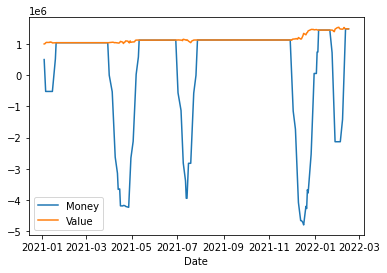

In [81]:
today = dt.date(2021, 1, 1)
simend = dt.date(2022, 2, 16)
data = yf.download(tickers_table,start=today,end=simend)
data['Close'].to_csv('etfsprices.csv')
prices = pd.read_csv("etfsprices.csv", index_col="Date", parse_dates=True)
data['Volume'].to_csv('etfsvolume.csv')
volumechanges = pd.read_csv("etfsvolume.csv", index_col="Date", parse_dates=True).pct_change()*100


#prices.reset_index(inplace=True)
#df.reset_index(inplace=True)
#print(df.head(10))
# initilaizing the labels
tickers = []

transactionid = 0

money = 1000000

portfolio = {}

activelog = []

transactionlog = []

value= {'Date':[],
        'Money':[],
       'Value': []}

main()
volume = pd.DataFrame(value)
volume.plot(x = "Date",y = ["Money", 'Value'])
#making a data frame of the transaction loging and recording it
tranc_df = pd.DataFrame(transactionlog)
# saving in csv file
tranc_df.to_csv('rsi_transaction_2010-2022.csv',index=False)    

# Results Summary

Strategy Ratings
1st Date Range: 1.1.2010 – 16.2.2022
1. EMA +39,926%
2. SMA +1,692%
3. Bollinger Bands +881%
4. RSI +440%
5. Volume Changes +34%

2nd Date Range: 1.1.2019 – 16.2.2022
1. SMA +276%
2. Bollinger Bands +243%
3. Volume Changes -11%
4. RSI -40%
5. EMA -7318%

3rd Date Range: 1.1.2021 – 16.2.2022
1. EMA +67%
2. Volume Changes +48%
3. Bollinger Bands +44%
4. SMA +26%
5. RSI +16%

# Conclusions

For a long-term strategy, the EMA is the most profitable in our project. While there is a question of reproducibility and correctness of the performance we got for the longer date range, the results show that we got the most of our portfolio with the EMA. The EMA gave us the best performance also for the shortest date range with a rise of 67% in just 14 months. In contrast, it would be wrong to use the technical analysis of Simple Moving Average for a long-term investment portfolio in the Sector ETF. At the beginning the original form of the SMA approach brough our portfolio to a loss in every date range. After some tries and errors, we decided to read the signals in an opposite fashion. Just after this modification we managed to produce some yield with the SMA strategy. On the other hand, while for the 2nd date range, the SMA gave us the best performance, the EMA actually gave us the worst performance by far. 
The RSI overall is a good technical analysis tool for Sector ETF, but the main problem with this strategy is that it didn’t work well during the negative Covid-19 impact in 2020. We assume that because the oscillators of the RSI used as a momentum indicators, at unusual times (like the Covid-19 outbreak), this strategy isn’t sensitive enough to identify correction pullbacks and price breakouts in the market.   
The Bollinger Bands strategy was the most solid strategy that we used. We got a decent yield in all three While this strategy is a relatively low risk approach, the solidary of it also limiting the potential rise in value. In our opinion, choosing to use Bollinger Bands for Sector ETF investments would be a good choice overall, especially for risk averse investors. 
The main point to take from the overall performance of the Volume Changes strategy is that the use of trading volume as an indicator to price movement isn’t a good strategy for the long run.  For the 2nd date range it is also not a good decision to depend on volume changes to guide us in the Sector ETF. It will be more profitable for shorter periods. In addition, it seems that you won’t trade a lot while using this strategy.
In this project, we saw just how good the performances were in 2021 in the Sector ETF, where we got a decent yield with every strategy in the 14-months period. There was a corrective price pullback at the start of 2022 that had a negative impact on our performance, which makes sense. 2021 acted as a lifeline after the catastrophic impact of Covid-19 pandemic on the global market.
From the results of this project determined by the performance of each strategy in every date range, we conclude that the best approach of investing in the Sector ETF is to use Moving Averages. For an extremely long or short period of time (1st and 3rd date ranges) it would be better to use Exponential Moving Average, but it seems that for a period of 3-4 years, the EMA produce horrible performance and it’s better to use SMA.
